## Trees

This notebook gives an example of using decision trees for regression. It
accompanies sections 8.3.1 and 8.3.2 in ISLR.

We'll first study classification trees, using the `Carseats` data.

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns

carseats = pd.read_csv("https://gist.githubusercontent.com/krisrs1128/20cf9de8917c003931e4aa5164703882/raw/1103d40f7b441eb87f0b122b04b05963aeeffa02/carseats.csv")
carseats

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No
...,...,...,...,...,...,...,...,...,...,...,...
395,12.57,138,108,17,203,128,Good,33,14,Yes,Yes
396,6.14,139,23,3,37,120,Medium,55,11,No,Yes
397,7.41,162,26,12,368,159,Medium,40,18,Yes,Yes
398,5.94,100,79,7,284,95,Bad,50,12,Yes,Yes


Right now, the `Sales` variable is actually continuous (number of carseats sold
per location, into thousands). To do classification on this data, we'll artificially
binarize the data.

In [0]:
carseats["y"] = carseats["Sales"].map(lambda z: 1. * (z > 8))


Before we can fit a decision tree, we need to convert the categorical variables
into their numerical encodings. This can be done using the `OneHotEncoder` class in `sklearn`'s `preprocessing` module.

In [0]:
from sklearn.preprocessing import OneHotEncoder


def encode_categoricals(df, var_list):
  """Apply OneHotEncoder(), one categorical column at a time."""
  enc = OneHotEncoder(sparse=False, drop="first")
  result = []

  for var in var_list:
    enc.fit(df[[var]])
    result_i = pd.DataFrame(enc.transform(df[[var]]))
    result_i.columns = [f"{var}_{i + 1}" for i in range(result_i.shape[1])]
    result.append(result_i)

  return pd.concat(result, axis=1)

cat_cols = ["ShelveLoc", "Urban", "US"]
x_cat = encode_categoricals(carseats, cat_cols)
combined = pd.concat([carseats.drop(cat_cols, axis=1), x_cat], axis=1)
combined


,Sales,CompPrice,Income,Advertising,Population,Price,Age,Education,y,ShelveLoc_1,ShelveLoc_2,Urban_1,US_1
0,9.50,138,73,11,276,120,42,17,1.0,0.0,0.0,1.0,1.0
1,11.22,111,48,16,260,83,65,10,1.0,1.0,0.0,1.0,1.0
2,10.06,113,35,10,269,80,59,12,1.0,0.0,1.0,1.0,1.0
3,7.40,117,100,4,466,97,55,14,0.0,0.0,1.0,1.0,1.0
4,4.15,141,64,3,340,128,38,13,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,12.57,138,108,17,203,128,33,14,1.0,1.0,0.0,1.0,1.0
396,6.14,139,23,3,37,120,55,11,0.0,0.0,1.0,0.0,1.0
397,7.41,162,26,12,368,159,40,18,0.0,0.0,1.0,1.0,1.0
398,5.94,100,79,7,284,95,50,12,0.0,0.0,0.0,1.0,1.0


Finally, we'll fit a decision tree. Notice though that we haven't rescaled the continuous variables. This was really
important for KNN. Why is it not so important for decision trees?

In [0]:
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.model_selection import train_test_split

x = combined.drop(["Sales", "y"], axis=1)
y = combined["y"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
model = DecisionTreeClassifier(min_samples_split=5)
model.fit(x_train, y_train)
y_hat = model.predict(x_test)

pd.crosstab(y_hat, y_test)


y,0.0,1.0
row_0,,
0.0,51,23
1.0,15,31


A nice thing about trees is that we can print out the full decision structure.

|--- ShelveLoc_1 <= 0.50
|   |--- Price <= 105.50
|   |   |--- CompPrice <= 124.50
|   |   |   |--- Age <= 32.00
|   |   |   |   |--- class: 1.0
|   |   |   |--- Age >  32.00
|   |   |   |   |--- Price <= 92.00
|   |   |   |   |   |--- ShelveLoc_2 <= 0.50
|   |   |   |   |   |   |--- Education <= 12.00
|   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |   |--- Education >  12.00
|   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |--- ShelveLoc_2 >  0.50
|   |   |   |   |   |   |--- Population <= 86.00
|   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |--- Population >  86.00
|   |   |   |   |   |   |   |--- Population <= 207.50
|   |   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |   |   |--- Population >  207.50
|   |   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |--- Price >  92.00
|   |   |   |   |   |--- Population <= 161.00
|   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |--- Population >  161.00
|

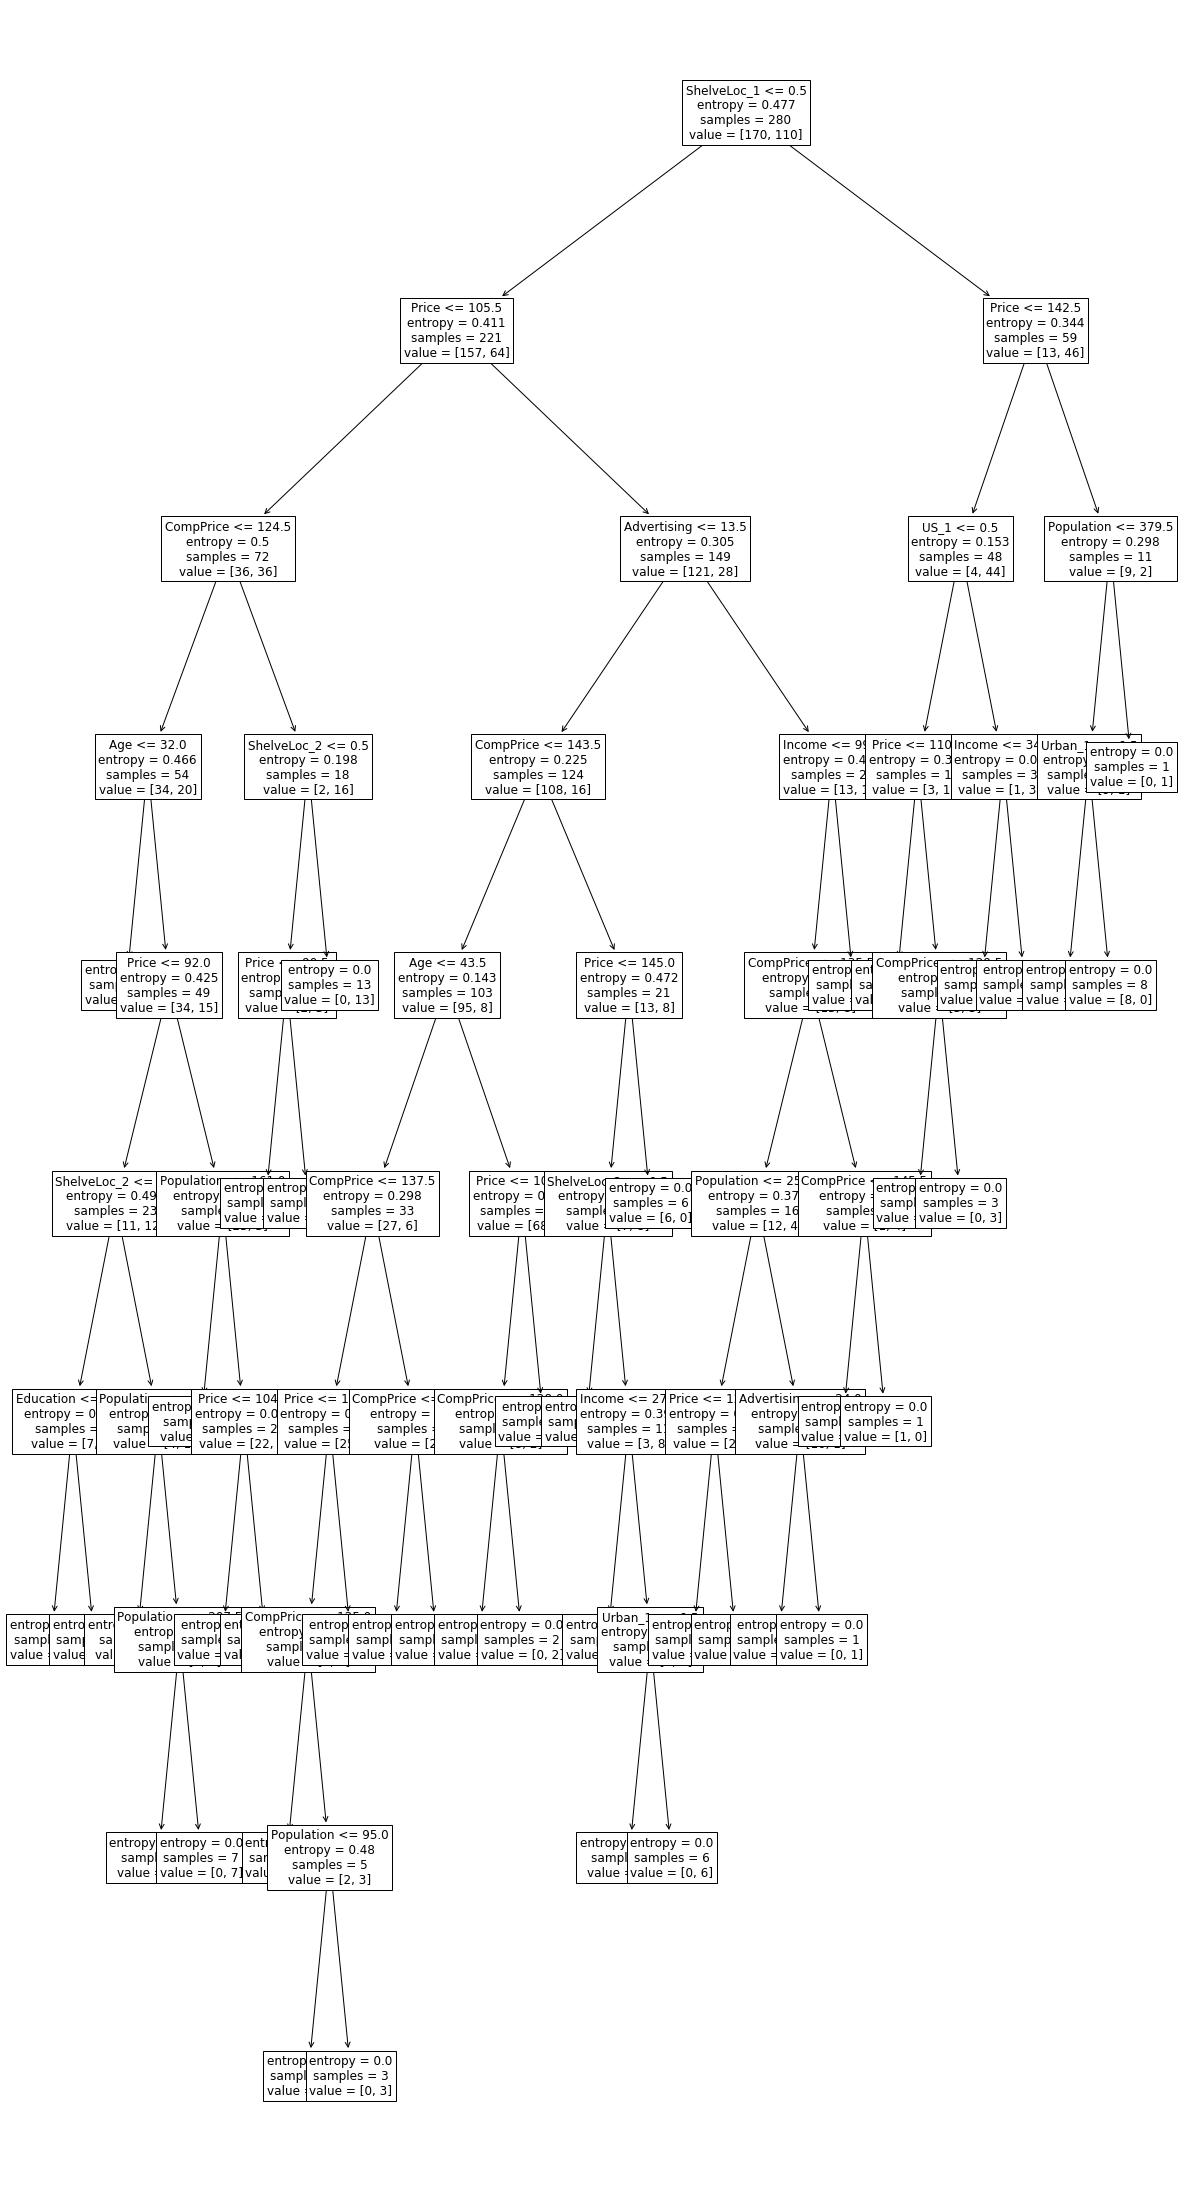

In [0]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20,40))
plot_tree(model, feature_names=list(x.columns.values), fontsize=12)
tree_rules = export_text(model, feature_names=list(x.columns.values))
print(tree_rules)


Let's go through a similar exercise, but for regression rather than
classification. There are no categorical predictors here, so we don't need to worry about encoding.

In [0]:
boston = pd.read_csv("https://gist.githubusercontent.com/krisrs1128/2c1ce8d004b1efc18b2d6e03e84a27c6/raw/9e95c9782b46f1ede7c288466390c8f937aecc08/boston.csv")
boston


,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273,21.0,393.45,6.48,22.0


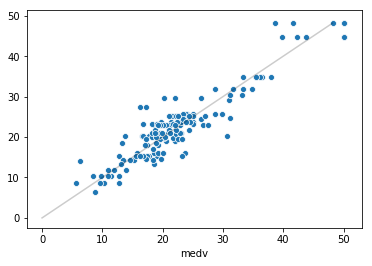

In [0]:
from sklearn.tree import DecisionTreeRegressor

x = boston.drop("medv", axis=1)
y = boston[["medv"]]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
model = DecisionTreeRegressor(min_samples_split=15)
model.fit(x_train, y_train)
y_hat = model.predict(x_test)

sns.lineplot([0, y_hat.max()], [0, y_hat.max()], color="black", alpha=0.2)
sns.scatterplot(y_test["medv"], y_hat)


It seems that there are a couple of points where the model is wildly off,
but other than that, things seem reasonable. Finally, we can ask, which variables were used to arrive at these predictions?

|--- lstat <= 9.64
|   |--- rm <= 7.44
|   |   |--- dis <= 1.48
|   |   |   |--- value: [50.00]
|   |   |--- dis >  1.48
|   |   |   |--- rm <= 6.72
|   |   |   |   |--- tax <= 222.50
|   |   |   |   |   |--- value: [31.45]
|   |   |   |   |--- tax >  222.50
|   |   |   |   |   |--- rm <= 6.54
|   |   |   |   |   |   |--- rad <= 1.50
|   |   |   |   |   |   |   |--- value: [18.92]
|   |   |   |   |   |   |--- rad >  1.50
|   |   |   |   |   |   |   |--- dis <= 4.46
|   |   |   |   |   |   |   |   |--- value: [25.09]
|   |   |   |   |   |   |   |--- dis >  4.46
|   |   |   |   |   |   |   |   |--- rm <= 6.08
|   |   |   |   |   |   |   |   |   |--- value: [21.05]
|   |   |   |   |   |   |   |   |--- rm >  6.08
|   |   |   |   |   |   |   |   |   |--- age <= 58.65
|   |   |   |   |   |   |   |   |   |   |--- tax <= 228.50
|   |   |   |   |   |   |   |   |   |   |   |--- value: [20.70]
|   |   |   |   |   |   |   |   |   |   |--- tax >  228.50
|   |   |   |   |   |   |   |   |   |   |   |

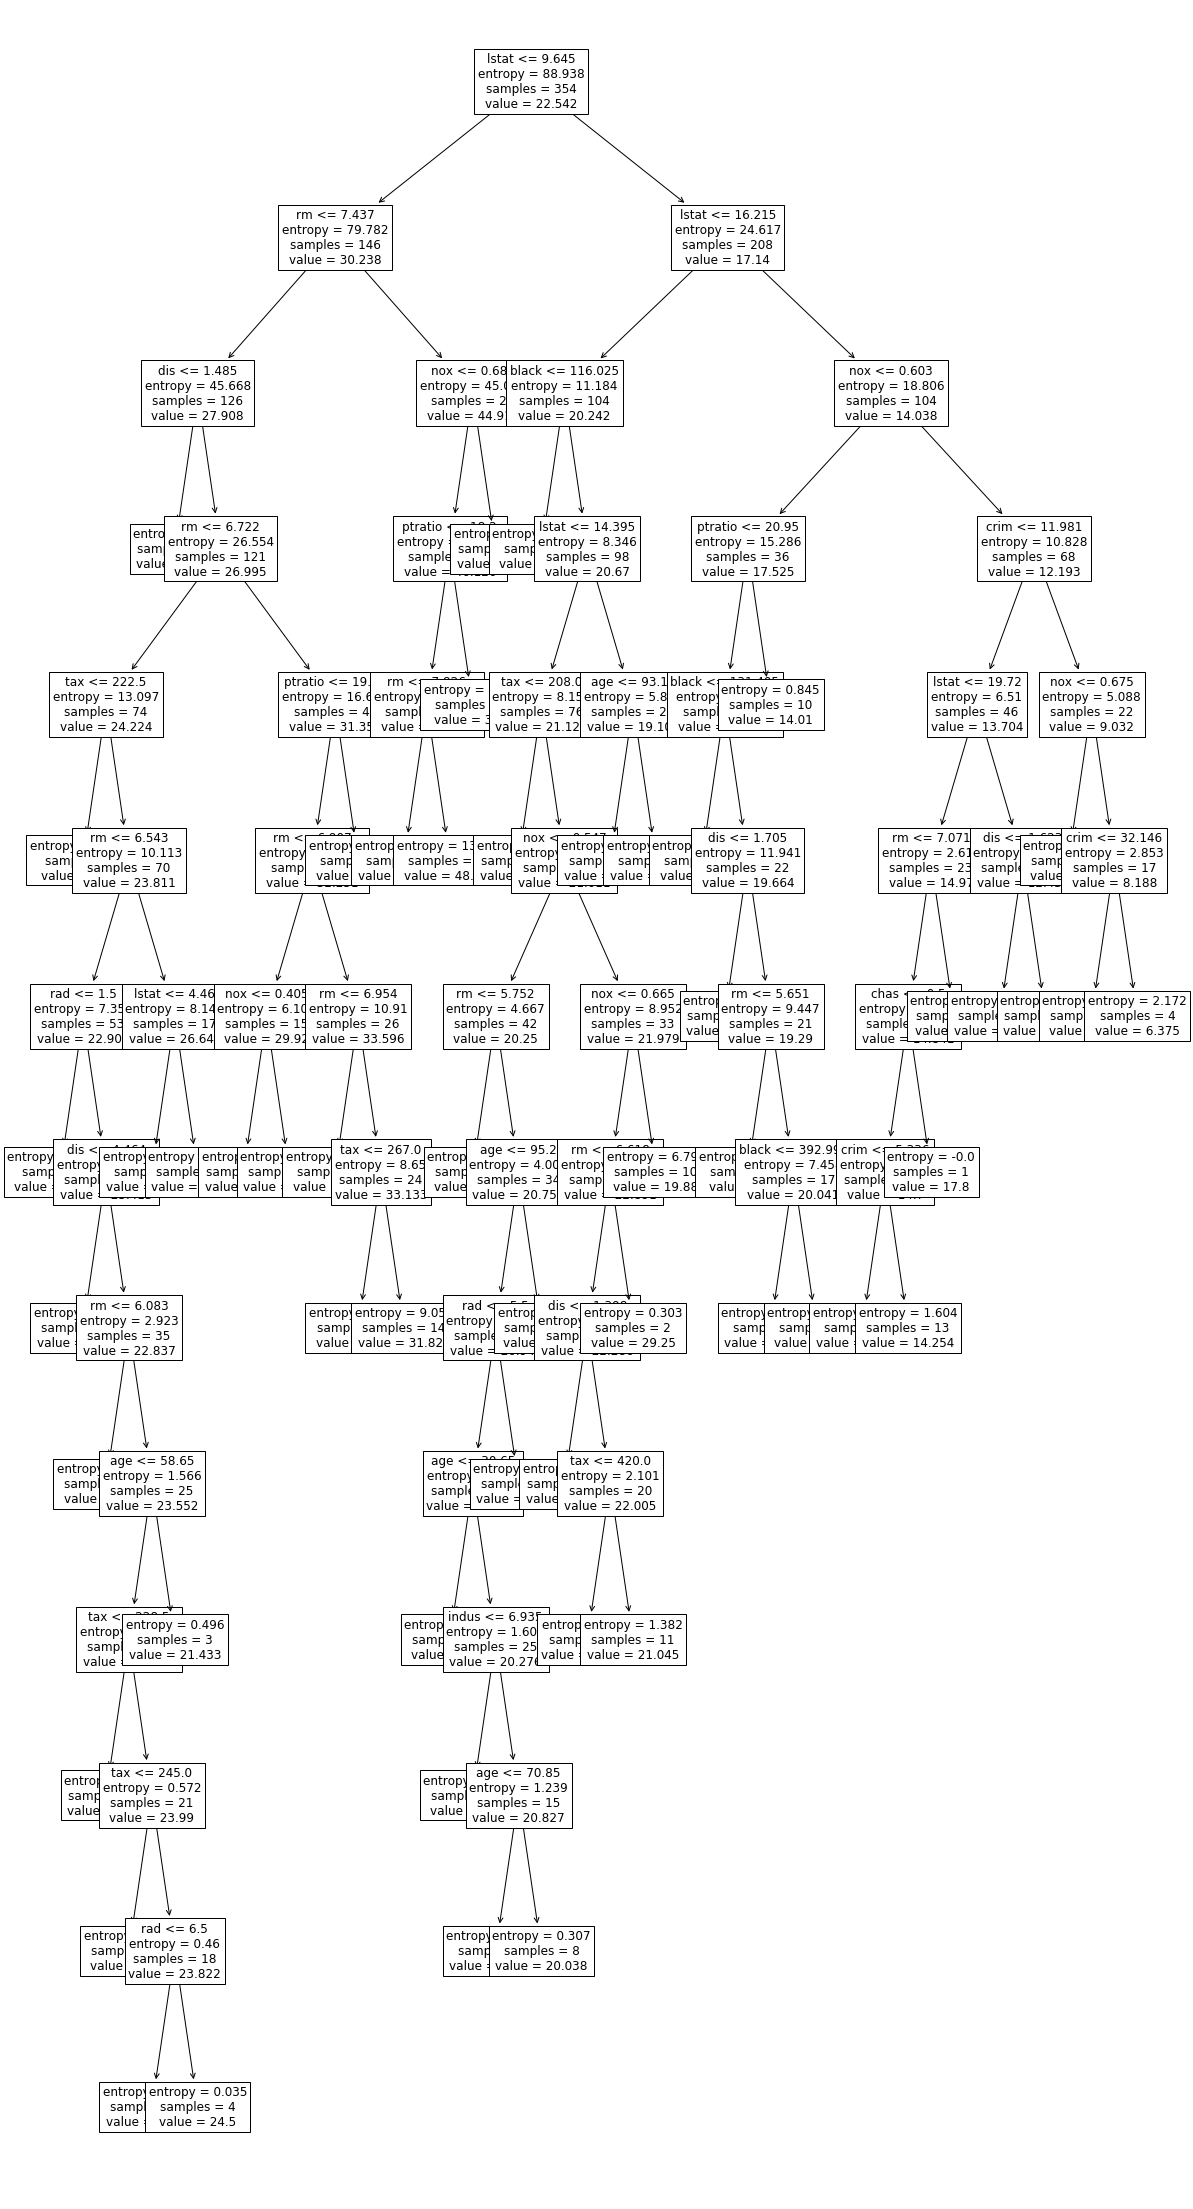

In [0]:
fig, ax = plt.subplots(figsize=(20,40))
plot_tree(model, feature_names=list(x.columns.values), fontsize=12)
tree_rules = export_text(model, feature_names=list(x.columns.values))
print(tree_rules)